# Загрузка и проверка данных

In [45]:
import pandas as pd

jumoreski_posts = pd.read_csv('jumoreski.csv')
jumoreski_posts.head()

,date,text
0,2023-04-12,ТЕЛЕГА: удивительное рядом\n \nhttps://t.me/my...
1,2023-04-14,"...у неё представления о том, как выглядят бипки?"
2,2023-04-14,- Может ли мyжчина забеpеменеть ? \n- Пока неи...
3,2023-04-14,📍 Пришла повестка? Армия не входит в планы? \n...
4,2023-04-14,Два шотландца встречаются в середине Индийског...


In [46]:
itis_posts = pd.read_csv('itis_kfu.csv')
itis_posts.head()
#

,date,text
0,2023-04-10,12-летие ИТИС!🎉 \nНаша самая приятная традиция...
1,2023-04-05,Мы приготовили для вас МЕГА-новости 😎 \n \nСлы...
2,2023-03-25,Live: ИТИС КФУ
3,2023-03-25,Live: ИТИС КФУ
4,2023-03-15,Студенты ИТИС стали стипендиатами Правительств...


## Объединение данных

In [47]:
jumoreski_posts['target'] = 'jumoreski'
itis_posts['target'] = 'itis'
posts = pd.concat([jumoreski_posts, itis_posts])
posts = posts.reset_index(drop=True)
posts.head()

,date,text,target
0,2023-04-12,ТЕЛЕГА: удивительное рядом\n \nhttps://t.me/my...,jumoreski
1,2023-04-14,"...у неё представления о том, как выглядят бипки?",jumoreski
2,2023-04-14,- Может ли мyжчина забеpеменеть ? \n- Пока неи...,jumoreski
3,2023-04-14,📍 Пришла повестка? Армия не входит в планы? \n...,jumoreski
4,2023-04-14,Два шотландца встречаются в середине Индийског...,jumoreski


# Предобработка данных

## Удаление emoji

In [48]:
import re

regrex_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)

posts['text'] = posts['text'].apply(lambda x: regrex_pattern.sub(r'', x))
posts.head()

,date,text,target
0,2023-04-12,ТЕЛЕГА: удивительное рядом\n \nhttps://t.me/my...,jumoreski
1,2023-04-14,"...у неё представления о том, как выглядят бипки?",jumoreski
2,2023-04-14,- Может ли мyжчина забеpеменеть ? \n- Пока неи...,jumoreski
3,2023-04-14,Пришла повестка? Армия не входит в планы? \n ...,jumoreski
4,2023-04-14,Два шотландца встречаются в середине Индийског...,jumoreski


## Удаление вспомогательных символов

In [49]:
posts['text'] = posts['text'].apply(lambda x: x.replace('\n', ' '))
posts['text'] = posts['text'].apply(lambda x: x.replace('\t', ' '))
posts['text'] = posts['text'].apply(lambda x: x.replace('\r', ' '))
posts['text'] = posts['text'].apply(lambda x: x.replace('  ', ' '))
posts.head()

,date,text,target
0,2023-04-12,ТЕЛЕГА: удивительное рядом https://t.me/myfav...,jumoreski
1,2023-04-14,"...у неё представления о том, как выглядят бипки?",jumoreski
2,2023-04-14,- Может ли мyжчина забеpеменеть ? - Пока неизв...,jumoreski
3,2023-04-14,Пришла повестка? Армия не входит в планы? 18...,jumoreski
4,2023-04-14,Два шотландца встречаются в середине Индийског...,jumoreski


## Удаление пунктуации

In [50]:
import string

posts['text'] = posts['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
posts['text'] = posts['text'].apply(lambda x: x.translate(str.maketrans('', '', '«»-—')))
posts['text'] = posts['text'].apply(lambda x: x.replace('  ', ' '))
posts.head()

,date,text,target
0,2023-04-12,ТЕЛЕГА удивительное рядом httpstmemyfavoriteju...,jumoreski
1,2023-04-14,у неё представления о том как выглядят бипки,jumoreski
2,2023-04-14,Может ли мyжчина забеpеменеть Пока неизвестн...,jumoreski
3,2023-04-14,Пришла повестка Армия не входит в планы 18 ап...,jumoreski
4,2023-04-14,Два шотландца встречаются в середине Индийског...,jumoreski


## Приведение к нижнему регистру

In [51]:
posts['text'] = posts['text'].apply(lambda x: x.lower())
posts.head()

,date,text,target
0,2023-04-12,телега удивительное рядом httpstmemyfavoriteju...,jumoreski
1,2023-04-14,у неё представления о том как выглядят бипки,jumoreski
2,2023-04-14,может ли мyжчина забеpеменеть пока неизвестн...,jumoreski
3,2023-04-14,пришла повестка армия не входит в планы 18 ап...,jumoreski
4,2023-04-14,два шотландца встречаются в середине индийског...,jumoreski


## Токенизация

In [52]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

corpus = {}
for i in range(len(posts)):
    corpus[i] = {
        'text': word_tokenize(posts['text'][i]),
        'target': posts['target'][i]
    }

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/timofejborisov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Лемматизация

In [53]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

def lemmatize(text):
    return [morph.parse(word)[0].normal_form for word in text]

for i, post in corpus.items():
    corpus[i]['text'] = lemmatize(post['text'])

## Удаление стоп-слов

Найдем стоп-слова по частоте встречаемости

In [54]:
word_count = {}
total_words = 0
for i, post in corpus.items():
    for word in post['text']:
        word_count[word] = word_count.get(word, 0) + 1
        total_words += 1

total_words, len(word_count)

(236820, 22134)

In [55]:
min_threshold = 0.00001
max_threshold = 0.99999

stop_words = []

for word, count in word_count.items():
    freq = count / total_words
    if freq < min_threshold or freq > max_threshold:
        stop_words.append(word)

stop_words[:20], len(stop_words)

(['бипка',
  'мyжчин',
  'забеpеменеть',
  'добросовестно',
  'покладай',
  'призывануть',
  'диагностировать',
  'непризывной',
  'чётко',
  'наметить',
  'httpsvkcccmfaz5',
  'шотландец',
  'акваланг',
  'смокинг',
  'дункан',
  'видеться',
  'поживать',
  'дражайший',
  'люси',
  'прихварывать'],
 13961)

In [56]:
def remove_stop_words(text):
    return [word for word in text if word not in stop_words]

for i, post in corpus.items():
    corpus[i]['text'] = remove_stop_words(post['text'])

In [57]:
corpus[0]

{'text': ['телега',
  'удивительный',
  'рядом',
  'httpstmemyfavoritejumoreski',
  'httpstmemyfavoritejumoreski',
  'httpstmemyfavoritejumoreski'],
 'target': 'jumoreski'}

## Сохранение предобработанных данных

In [58]:
corpus_df = pd.DataFrame(corpus).T
corpus_df.head()

,text,target
0,"[телега, удивительный, рядом, httpstmemyfavori...",jumoreski
1,"[у, она, представление, о, тот, как, выглядеть]",jumoreski
2,"[мочь, ли, пока, неизвестно, но, всё, сообщест...",jumoreski
3,"[прийти, повестка, армия, не, входить, в, план...",jumoreski
4,"[два, встречаться, в, середина, индийский, оке...",jumoreski


In [59]:
corpus_df.to_csv('corpus.csv', index=False)

# Наивный байесовский классификатор

## Разделение данных на обучающую и тестовую выборки

In [60]:
import numpy as np
from sklearn.model_selection import train_test_split

X = corpus_df['text']
y = corpus_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2864,), (716,), (2864,), (716,))

In [61]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

concat_train = np.concatenate((X_train.reshape(-1, 1), y_train.reshape(-1, 1)), axis=1)
concat_test = np.concatenate((X_test.reshape(-1, 1), y_test.reshape(-1, 1)), axis=1)
concat_train[:5]

array([[list(['приходить', 'както', 'девушка', 'к', 'конфуций', 'и', 'говорить', 'конфуций', 'почему', 'это', 'нормально', 'а', 'плохо', 'конфуций', 'от', 'чаемый', 'и', 'крикнуть', 'да', 'ёб', 'твой', 'мать', 'опять', 'забыть', 'дверь', 'на', 'закрыть', 'идти', 'отсюда']),
        'jumoreski'],
       [list(['кто', 'носить', 'фирма', 'и', 'рожа', 'фирма', 'тот', 'твой', 'мамаша', 'дать', 'ну', 'а', 'ты', 'никто', 'не', 'дать']),
        'jumoreski'],
       [list(['если', 'бы', 'я', 'платить', 'за', 'каждый', 'существующий', 'гендер', '100', 'доллар', 'то', 'я', 'бы', 'не', 'хватить', 'на']),
        'jumoreski'],
       [list(['идти', '100', 'негр', 'по', 'пустыня', 'встретить', 'джина', '99', 'говорить', 'себя', 'свой', 'близкий', 'и', 'тот', 'кто', 'это', 'читать', 'и', 'они', 'семья', 'от', 'а', 'от', 'смех', 'весь', 'снова']),
        'jumoreski'],
       [list(['если', 'вы', 'думать', 'что', 'студент', 'итис', 'только', 'учиться', 'вот', 'вы', 'новый', 'статья', 'от', 'club15347

## Обучение классификатора

In [62]:
import numpy as np
import joblib

class Naive_bayes():

    def __init__(self):
        self.classes_cnt = {}  # словарь, хранящий число элементов класса и общее число признаков в классе
        self.freq = {}         # словарь, хранящий число вхождений признака в класс
        self.unique = set()    # множество уникальных признаков в данных
        self.fitted = False    # флаг, определяющий, обучен ли классификатор

    def fit(self, dataset):
        for features, label in dataset:
            if label not in self.classes_cnt: #Проверяем, есть ли метка label в словаре classes_cnt
                self.classes_cnt[label] = [0, 0]
            self.classes_cnt[label][0] += 1 #Отслеживание количества элементов с этой меткой.
            for feature in features:
                if (feature, label) not in self.freq:
                    self.freq[(feature, label)] = 0
                self.freq[(feature, label)] += 1
                self.classes_cnt[label][1] += 1 #Подсчет количества уникальных признаков с этой меткой.
                self.unique.add(feature)
        self.fitted = True

    def predict(self, features, alpha=1):
        if not self.fitted: return None # Если модель не обучена, возвращается значение None
        dataset_cnt = 0
        for label in self.classes_cnt:
            dataset_cnt += self.classes_cnt[label][1] # Вычисляется общее количество признаков во всех классах

        max_prob = -1
        max_label = None
        for cls in self.classes_cnt:
            cls_prob = self.classes_cnt[cls][0] / dataset_cnt # Вычисляется априорная вероятность класса
            for feature in features:
                if (feature, cls) in self.freq: # Если признак уже встречался в классе, то вычисляется его вероятность по формуле Наивного Байеса
                    cls_prob += (self.freq[(feature, cls)] + alpha) / (self.classes_cnt[cls][1] + alpha * len(self.unique))
                else: # Если признак не встречался в классе, то используется сглаживание с параметром alpha
                    cls_prob += alpha / (self.classes_cnt[cls][1] + alpha * len(self.unique))
            if cls_prob > max_prob: # Выбирается класс с наибольшей вероятностью
                max_prob = cls_prob
                max_label = cls
        return max_label # Возвращается метка класса с наибольшей вероятностью

    def export_model(self, path='dicts.pkl'):
        model = self.classes_cnt, self.freq, self.unique
        joblib.dump(model, 'dicts.pkl')
        return model

    def import_model(self, path='dicts.pkl'):
        self.classes_cnt, self.freq, self.unique = joblib.load(path)
        self.fitted = True

nb = Naive_bayes()
nb.fit(concat_train)
nb.export_model('dicts.pkl')
nb.import_model('dicts.pkl')

for k, item in enumerate(concat_test):
    print(nb.predict(item[0], alpha=1), ' : ', item[1])
    if k == 10: break

jumoreski  :  jumoreski
jumoreski  :  jumoreski
jumoreski  :  jumoreski
jumoreski  :  itis
jumoreski  :  jumoreski
jumoreski  :  jumoreski
jumoreski  :  jumoreski
itis  :  itis
jumoreski  :  jumoreski
jumoreski  :  jumoreski
jumoreski  :  jumoreski


## Оценка качества классификатора

In [63]:
y_pred = []
for item in concat_test:
    y_pred.append(nb.predict(item[0], alpha=1))

y_pred = np.array(y_pred)

In [64]:
# map labels to numbers
y_test = np.array([1 if label == 'jumoreski' else 0 for label in y_test])
y_pred = np.array([1 if label == 'jumoreski' else 0 for label in y_pred])

In [65]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('Accuracy score:', accuracy_score(y_test, y_pred))
print('Precision score:', precision_score(y_test, y_pred))
print('Recall score:', recall_score(y_test, y_pred))
print('F1-Score score:', f1_score(y_test, y_pred))

Accuracy score: 0.9385474860335196
Precision score: 0.970074812967581
Recall score: 0.9239904988123515
F1-Score score: 0.9464720194647203


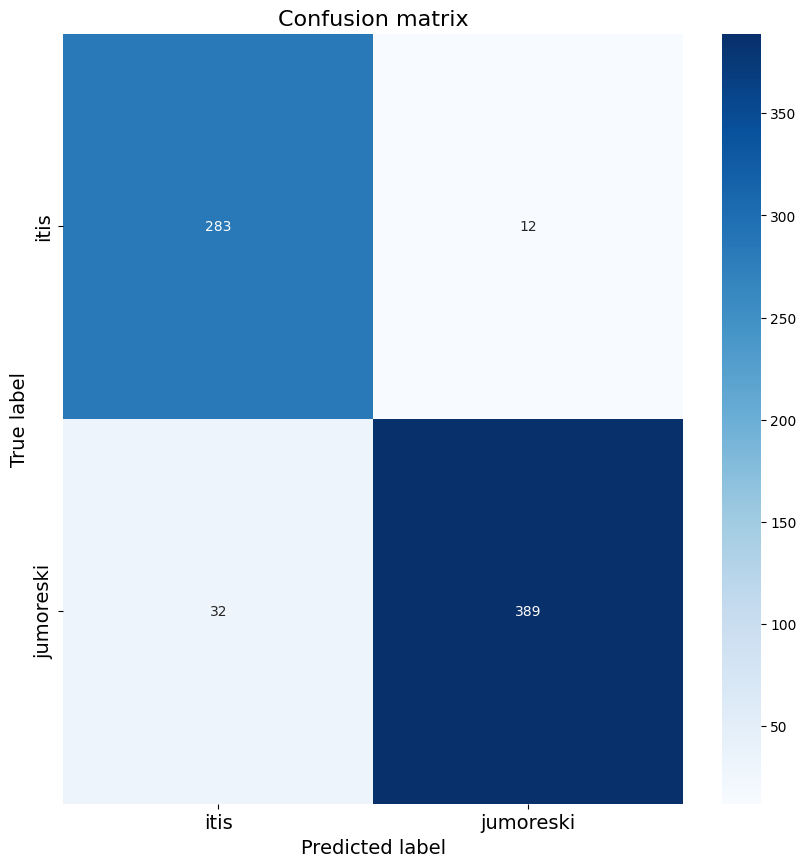

In [66]:
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix', fontsize=16)
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)

plt.xticks([0.5, 1.5], ['itis', 'jumoreski'], fontsize=14)
plt.yticks([0.5, 1.5], ['itis', 'jumoreski'], fontsize=14)
plt.show()